# Comparing strategies

With a fine tuned model and a stylistically informed prompt, we can compare the two, along with the basic model.

## Preliminary

Set up the device we are using for inference.

In [1]:
import torch

DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}\n")

Using device: mps



Set the logging level.

In [2]:
import transformers

transformers.logging.set_verbosity_error()

/Users/charles/Documents/code/stylometry/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set up some helper functions.

In [3]:
from transformers import AutoProcessor, AutoModelForVision2Seq
from huggingface_hub import model_info
from PIL import Image
from typing import Optional

def get_model_processor(model_id):
    """
    Load the processor for the given model ID. If it fails, try to load the base model's processor.
    Args:
        model_id (str): The model ID to load the processor for.
    Returns:
        processor (AutoProcessor): The loaded processor.
    """
    try:
        processor = AutoProcessor.from_pretrained(model_id)
        return processor
    except Exception as e:
        if model_info(model_id).card_data.base_model:
            return get_model_processor(model_info(model_id).card_data.base_model)
        else:
            raise Exception(f"Failed to load processor for model {model_id}.") from e


def generate_ouput(model_id: str, prompt: str = "Describe this image", system_prompt: str = "You are a helpful assistant.", image: Optional[Image.Image] = None) -> str:
    processor = get_model_processor(model_id)

    model = AutoModelForVision2Seq.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        _attn_implementation="flash_attention_2" if DEVICE == "cuda" else "eager",
    ).to(DEVICE)

    user_content = [{"type": "text", "text": prompt}]
    if image is not None:
        user_content.insert(0, {"type": "image", "image": image})
    messages = [
        {
            "role": "system",
            "content": system_prompt,
        },
        {
            "role": "user",
            "content": user_content
        },
    ]

    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = inputs.to(model.device)

    generated_ids = model.generate(**inputs, max_new_tokens=256)
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )

    full_text = generated_texts[0]

    # Remove the prompt from the output
    return full_text.split("Assistant:")[1].strip()


## Image

We'll use the same image for each test.

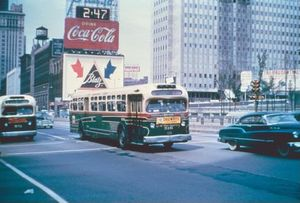

In [4]:
from transformers.image_utils import load_image

# See work: https://dc.library.northwestern.edu/items/f9f7d7ed-ca03-4ad7-b154-249d689211eb
image = load_image("https://iiif.dc.library.northwestern.edu/iiif/3/1ece48b0-8a49-491d-9f3f-90dc8bcca1ac/full/!300,300/0/default.jpg")

display(image)

<div style="border-radius: .5rem; border:2px solid #ac9a14; background-color: #ffe900; max-width: fit-content; max-height: fit-content; padding: 1rem; color: black; line-height: 1;">
In the <em>Observations</em> section of each strategy output references to generated output may not appear on subsequent generation.
<div>

## Base model

We'll first see the output from the base model.

In [5]:
default_output = generate_ouput("HuggingFaceTB/SmolVLM-Instruct", image=image)
print(default_output)

The image depicts a scene from the early 1950s, likely taken in New York City, given the presence of the iconic Coca-Cola advertisement on a building. The advertisement features the iconic Coca-Cola logo and the slogan "Drink Coca-Cola" in white text against a red background. The building itself is adorned with a large sign that reads "Coca-Cola" in white letters against a red background, indicating the company's presence in the city.

In the foreground, there is a bus with a green and white exterior. The bus has a large number of windows and a visible interior, suggesting it is a public transportation vehicle. The bus is moving through a busy urban street, with cars and other vehicles visible in the background. The street is lined with tall buildings, indicating a densely populated city area.

On the left side of the image, there is a bus stop with a sign that reads "Bus Stop" in white letters against a red background. This suggests that the bus is a public transportation system, and 

### Observations

Without any additional prompting, the model produces a very thorough description of the image.

This description, however, is not in keeping with common library standards.

#### Content

Parts of the description are speculative, such as that it was taken in New York City; the image is from Chicago. Though it correctly identifies the images as from the 1950's there is no reasong given for assigning that date.

Parts of not correct, such as the "bus stop" sign.

Additionally, by fronting the information about the Coca-Cola sign, focus is lost on the subject of the image — the bus.

#### Style

The style of the output is verbose. 

It uses hypotaxis which creates false relationships (e.g. "indicating the company's presence in the city.")

There is a tendency towards aggrandizing language (e.g. "iconic") and energetic language (e.g. "bustling") both of which are subjective.

## Stylistically informed prompt

In [6]:
generated_prompt = ""
with open("llm_prompt.txt", "r") as f:
    generated_prompt = f.read()

print(f"----- Prompt -----\n{generated_prompt.strip()}\n---- \\Prompt -----\n")

style_prompt = generate_ouput("HuggingFaceTB/SmolVLM-Instruct", image=image, prompt=generated_prompt + "\nDescribe this image")
print(style_prompt)

----- Prompt -----
Follow these guidelines when describing an image:

1.  Use short sentences that are around 6-21 words long. Examples:
    -   An unidentified man sits between them.
    -   Digital image scanned from black and white negative.

2.  Use a 0.27 proportion of stop words in your sentences. Examples:
    -   Clipping from Folknik's newsletter about Teatro Campesino.
    -   Flyer advertising double feature movie screenings of "Tarzan the Ape Man" and the Little Rascals' "Fly My Kite," with free bananas for the first 10 guests at each show

3. Use a comma frequency between 0.00 and 0.02. Examples:
    -   Mississippi John Hurt (playing guitar) and Bess Lomax Hawes at a Berkeley Folk Music Festival workshop.
    -   Bearded man.

4. Aim for a passive voice ratio close to 0.03. Examples:
    -   Template for form letters to Berkeley Folk Music Festival artists and folklorists
    -   Digital image scanned from black and white negative.
---- \Prompt -----

A green and white bu

### Observations

The model's output is succinct. The style is aligned with library standards, but the content is not.

#### Content

Like the previous strategy, some parts of the description are not accurate (e.g. "people standing on the sidewalk") or unable to be discerned visibly from the image (e.g. "the bus is carrying passengers").

#### Style

The style is more aligned with library standards than the previous strategy.

Sentences are short and no hypotaxis is used (only parataxis) creating fewer false relationships.

There is no aggrandizing language, but there are still subjective adjectives (e.g. "large").

## Fine tuned model

In [7]:
fine_tuned = generate_ouput("charlesLoder/SmolVLM-Instruct-library-metadata", image=image)
print(fine_tuned)

A vintage photograph of a bus driving down a busy street with a large Coca-Cola sign on the side of a building.


### Observations

The model's output in terms of content and style are more aligned with library standards.

#### Content

Due to being constrained by terse and succinct style of the fine tuning data, the model in keeping with this style has fewer opportunities to produce inaccurate information.

The model keeps keeps the bus as the subject of the image (though not in a grammatical sense) and incoroporates prominent background elements — other cars (i.e. "busy street") and the sign with Cocap-Cola on it.

It is not without some content issues. The model correctly identifies the image as a photograph, though that can be inferred from the quality of the image, it is not explicitly stated.

#### Style

The whole description is one sentence fragment.

Many of the image descriptions in the training data represent the complement of an inferred preceding copula (e.g. This image is <IMAGE_DESCRIPTION>), and the description provded by the model reflects that as constrated by the previous strategy (e.g. A green and white buys drives down a busy city stree).

Though free from aggrandizing language, there is still some energetic language (e.g. "busy") which can be subjective in nature.


## Summary

All three strategies have pros and cons, but only fine tuning aligns most closely with common metadata practices.

#### Base model

##### Pros

There is little to no effort to generate image descriptions.

##### Cons

Outputs are the least aligned with metadata practices.

#### Stylistically informed prompt

##### Pros

Outpus are improved both in terms of content and style.

This is most flexible option as the prompt can be used with any model.

**Note:**
The current prompt can be improved in various ways such as:

- limiting the entire response, not just sentences
- casting image descriptions as sentence fragment

##### Cons

There is a startup cost required to processing the data and developing a prompt that produces the desired outcome.

The prompt is included in the token count.

#### Fine tuning

##### Pros

Outputs are the most aligned with metadata practices.

No additional prompting is needed to ensure the style is accurate.

##### Cons

There is significantly higher startup costs.

Fine tuning cannot be ported to other models.
